# Analysis of Numerical Experiments

**Setting addressed by [Montanari & Saeed '22, Hu & Lu '22]:**

Given $n$ i.i.d samples $\{(z_i, y_i)\}_{i=1}^{n}$, with covariates $z_i \in \mathbb{R}^d$ and labels $y_i \in \mathbb{R}$. The class of regression functions is given by

$$
f(z; \Theta) = F(\Theta^\top \phi(z))
$$

where $\phi: \mathbb{R}^d \to \mathbb{R}^p$ is a fixed featurization map, $\Theta = (\theta_1, ..., \theta_k) \in \mathbb{R}^{p \times k}$ denotes $k$ linear projections (parameters to be optimized via ERM), and $F: \mathbb{R}^k \to \mathbb{R}$ is a fixed function.

The parameters $\Theta$ are obtained via emprical risk minimization (ERM) by solving:

$$
\text{minimize} \hat{R}_n(\Theta; \mathbf{Z}, \mathbf{y}) := \frac{1}{n} \sum_{i=1}^{n} L(f(z_i; \Theta), y_i) + r(\Theta),
$$

where $L: \mathbb{R} \times \mathbb{R} \to \mathbb{R}_{\geq 0}$ is a loss function, and $r: \mathbb{R}^{p \times k}$ is a regularizer over the parameters $\Theta$, and $\mathbf{Z} = (z_1, ..., z_n) \in \mathbb{R}^{d \times n}, \mathbf{y} = (y_1, ..., y_n)$.

High-dimensional asymptotics: $\lim_{n\to\infty} \frac{p(n)}{n} = \gamma \in (0, \infty)$.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import utils

In [2]:
import scienceplots
plt.style.use('grid')

In [3]:
import datetime

In [4]:
def plot_band(ax, x, data, sem_multiplier=2, label=None):
    y = np.mean(data, axis=1)
    y_err = sem_multiplier * scipy.stats.sem(data, axis=1)
    ax.plot(x, y, label=label)
    ax.fill_between(x, y - y_err, y + y_err, alpha=0.5)


## Experiment: Numerical Example from [Hu & Lu '22]

This experiment largely follows the numerical experiment from [Hu & Lu '22].

**data:**

$(z_i, y_i)$, $z_i \sim \mathcal{N}(0, I_d)$, $y_i = \psi(\langle \beta^*, z_i \rangle)$, $\psi(t) = t$, $\beta^* \in \mathbb{R}^d$, $\lVert \beta^* \rVert_2 = 1$ unknown parameters' vector.

**Model and feature vectors:**

$x_i = \phi(z_i) \in \mathbb{R}^p$, where $\phi$ is a random features model (2-layer network with $p$ hidden neurons and fixed first layer weights)

$$
\phi(z) = \phi_{\text{RF}}(z) := (\sigma(w_1^\top), ..., \sigma(w_p^\top z))^\top, \ \sigma = \text{relu}, \ \{w_j\}_{j=1}^{p} \sim \text{Unif}(\mathbb{S}^{d-1}(1))
$$

I.e.: $f(z; a) := \sum_{i=1}^{p} a_i \sigma(\langle w_i, z \rangle)$. $L(x, y) = (x-y)^2, r(\Theta) = 0$

**Parameters of numerical experiments**
$$n = 600, d = 200$$

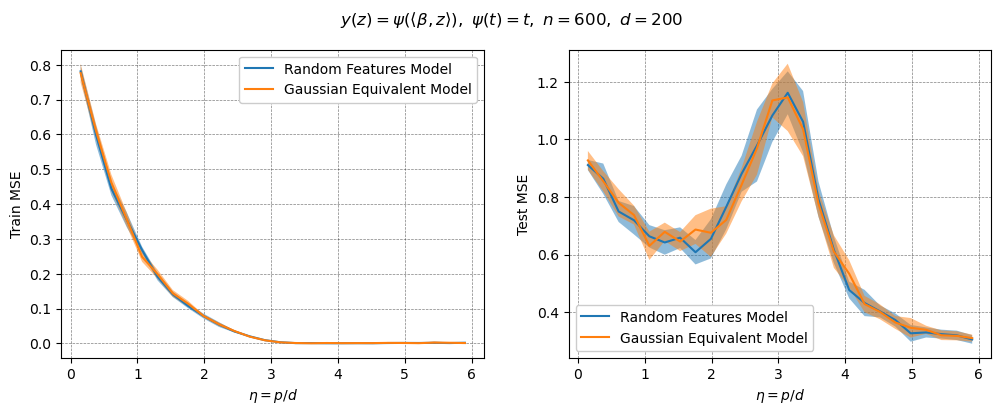

In [5]:
# plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

results_file = 'results/results_exp2_2023-04-05-1539/random_feats.npy'
results = np.load(results_file, allow_pickle=True).item()

train_mse_results = results['train_mse']
test_mse_results = results['test_mse']
ps = results['ps']
n_train = results['args'].n_train
d = results['args'].d

etas = ps/d
gammas = ps/n_train
plot_band(ax1, etas, train_mse_results, sem_multiplier=2, label='Random Features Model')
plot_band(ax2, etas, test_mse_results, sem_multiplier=2, label='Random Features Model')


results_file = 'results/results_exp2_2023-04-05-1539/gaussian_equiv.npy'
results = np.load(results_file, allow_pickle=True).item()

train_mse_results = results['train_mse']
test_mse_results = results['test_mse']
ps = results['ps']
n_train = results['args'].n_train
d = results['args'].d

etas = ps/d
gammas = ps/n_train
plot_band(ax1, etas, train_mse_results, sem_multiplier=2, label='Gaussian Equivalent Model')
plot_band(ax2, etas, test_mse_results, sem_multiplier=2, label='Gaussian Equivalent Model')

ax1.set_ylabel('Train MSE')
ax2.set_ylabel('Test MSE')
ax1.set_xlabel('$\eta = p / d$')
ax2.set_xlabel('$\eta = p / d$')
ax1.legend();
ax2.legend();

fig.suptitle('$y(z) = \\psi\\left(\\langle \\beta, z \\rangle\\right),\\ \\psi(t) = t, \\ n = 600, \\ d = 200$');

## Experiment: Sigmoid Feature Transformation

$$y = \langle \beta, \psi(z) \rangle, \ \psi(t) = \frac{1}{1 + \exp(-t)}, \ z_i \sim \mathcal{N}(0, I_d),\ \beta \sim \text{Uniform}(\mathbb{S}^{d-1})$$

$$n = 1200, \ d= 400, \gamma \in [0.05, 2], \phi_{RF} = \text{relu},\ \ell(x,y) = (x-y)^2$$

In [6]:
runs_df = utils.get_wandb_project_table(project_name='universality-erm-logistic-feat-transform', entity='Awni00',
    attr_cols=('name',), config_cols='all', summary_cols='all')

In [7]:
agg_runs_df = runs_df.groupby(['group', 'p'])
metrics = ['train_mean_squared_error', 'test_mean_squared_error']
agg_runs_df = agg_runs_df[metrics].agg(
    [np.mean, np.max, scipy.stats.sem, len])

agg_runs_df = agg_runs_df.reset_index()
agg_runs_df.columns = [' '.join(col).strip() for col in agg_runs_df.columns.values]

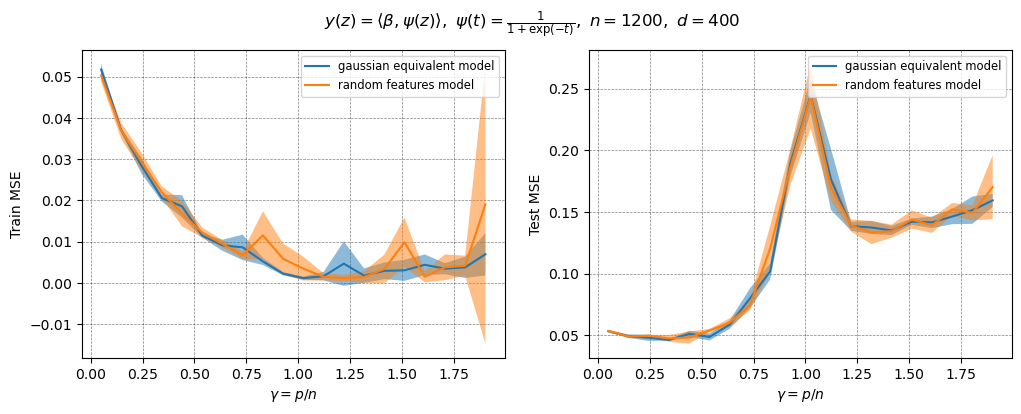

In [8]:
fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)

metric = 'train_mean_squared_error'
for group in agg_runs_df.group.unique():
    group_df = agg_runs_df[agg_runs_df.group==group]
    
    x = group_df['p'] / 1200
    y = group_df[f'{metric} mean']
    y_err = 2*group_df[f'{metric} sem']

    ax1.plot(x, y, label=group)

    ax1.fill_between(x, y - y_err, y + y_err, alpha=0.5)

ax1.set_xlabel('$\gamma = p/n$');
ax1.set_ylabel('Train MSE');
ax1.legend(loc='upper right', fontsize='small', fancybox=True, frameon=True, framealpha=0.8);

metric = 'test_mean_squared_error'
for group in agg_runs_df.group.unique():
    group_df = agg_runs_df[agg_runs_df.group==group]
    
    x = group_df['p'] / 1200
    y = group_df[f'{metric} mean']
    y_err = 2*group_df[f'{metric} sem']

    ax2.plot(x, y, label=group)

    ax2.fill_between(x, y - y_err, y + y_err, alpha=0.5)

ax2.set_xlabel('$\gamma = p/n$');
ax2.set_ylabel('Test MSE');
ax2.legend(loc='upper right', fontsize='small', fancybox=True, frameon=True, framealpha=0.8);

fig.suptitle('$y(z) = \\langle \\beta, \\psi(z) \\rangle,\\ \\psi(t) = \\frac{1}{1 + \\exp(-t)}, \\ n = 1200, \\ d = 400$');

## Experiment: Square Feature Transformation

$$y = \langle \beta, \psi(z) \rangle, \ \psi(t) = t^2, \ z_i \sim \mathcal{N}(0, I_d),\ \beta \sim \text{Uniform}(\mathbb{S}^{d-1})$$

$$n = 1200, \ d= 400, \gamma \in [0.05, 2], \phi_{RF} = \text{relu}, \ell(x,y) = (x-y)^2$$

In [9]:
runs_df = utils.get_wandb_project_table(project_name='universality-erm-square-feat-transform', entity='Awni00',
    attr_cols=('name',), config_cols='all', summary_cols='all')

In [10]:
agg_runs_df = runs_df.groupby(['group', 'p'])
metrics = ['train_mean_squared_error', 'test_mean_squared_error']
agg_runs_df = agg_runs_df[metrics].agg(
    [np.mean, np.max, scipy.stats.sem, len])

agg_runs_df = agg_runs_df.reset_index()
agg_runs_df.columns = [' '.join(col).strip() for col in agg_runs_df.columns.values]

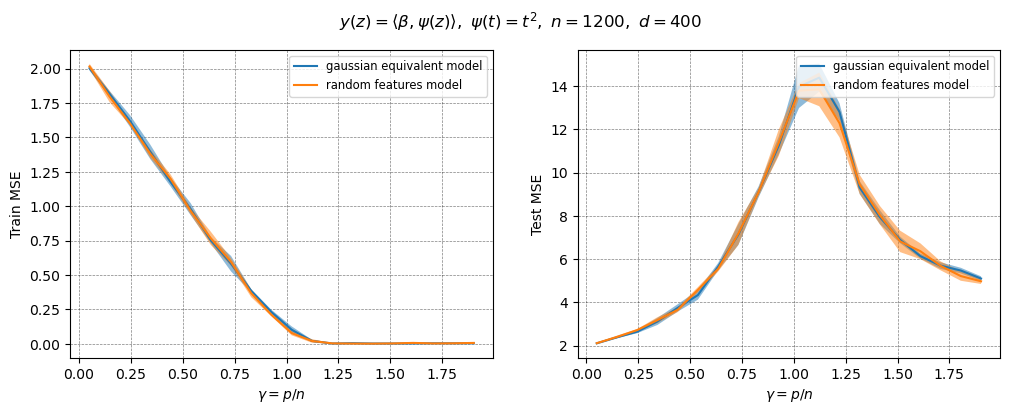

In [11]:

fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)

metric = 'train_mean_squared_error'
for group in agg_runs_df.group.unique():
    group_df = agg_runs_df[agg_runs_df.group==group]
    
    x = group_df['p'] / 1200
    y = group_df[f'{metric} mean']
    y_err = 2*group_df[f'{metric} sem']

    ax1.plot(x, y, label=group)

    ax1.fill_between(x, y - y_err, y + y_err, alpha=0.5)

ax1.set_xlabel('$\gamma = p/n$');
ax1.set_ylabel('Train MSE');
ax1.legend(loc='upper right', fontsize='small', fancybox=True, frameon=True, framealpha=0.8);

metric = 'test_mean_squared_error'
for group in agg_runs_df.group.unique():
    group_df = agg_runs_df[agg_runs_df.group==group]
    
    x = group_df['p'] / 1200
    y = group_df[f'{metric} mean']
    y_err = 2*group_df[f'{metric} sem']

    ax2.plot(x, y, label=group)

    ax2.fill_between(x, y - y_err, y + y_err, alpha=0.5)

ax2.set_xlabel('$\gamma = p/n$');
ax2.set_ylabel('Test MSE');
ax2.legend(loc='upper right', fontsize='small', fancybox=True, frameon=True, framealpha=0.8);

fig.suptitle('$y(z) = \\langle \\beta, \\psi(z) \\rangle,\\ \\psi(t) = t^2, \\ n = 1200, \\ d = 400$');